In [1]:
# Import thư viện cần thiết
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error
from sklearn.metrics import PredictionErrorDisplay
from statsmodels.graphics.tsaplots import plot_pacf

<h2>1. Data ARE-Historical-Data-final

In [2]:
# Import data
df = pd.read_csv('ARE-Historical-Data-final.csv', index_col='Date', parse_dates=True)
df1=df.reset_index()['Price']

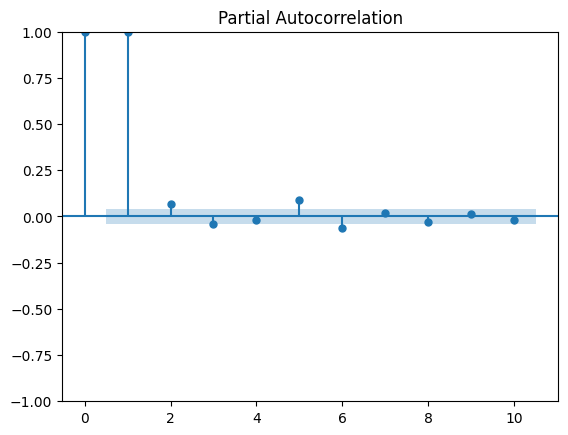

In [3]:
# Kiểm tra sự tương quan một phần PAFC
plot_pacf(df1, lags=10)
plt.show()

In [4]:
# Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [5]:
# Chia thành các tập train, test, validation
train_size = int(0.6 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [6]:
# Hàm tạo dữ liệu cho mô hình
def create_dataset(dataset, lookback, horizon):
    X, y = [], []
    for i in range(len(dataset)-lookback-horizon+1):
        X.append(dataset[i:(i+lookback), :])
        y.append(dataset[(i+lookback):(i+lookback+horizon), 0])
    return np.array(X), np.array(y)

In [7]:
# Thiết lập thông số mô hình
lookback = 5
horizon = 1
n_features = 1

In [8]:
# Tạo dữ liệu cho mô hình
X_train, y_train = create_dataset(train_data, lookback, horizon)
X_test, y_test = create_dataset(test_data, lookback, horizon)
X_val, y_val = create_dataset(val_data, lookback, horizon)

In [9]:
# Xây dựng mô hình NNAR
model = Sequential()
model.add(LSTM(64, input_shape=(lookback, n_features), return_sequences=True))
model.add(LSTM(32, return_sequences=False))
model.add(Dense(horizon))
model.compile(loss='mse', optimizer='adam')

In [10]:
# Huấn luyện mô hình
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), verbose=2)

Epoch 1/50
40/40 - 3s - loss: 0.0297 - val_loss: 0.0365 - 3s/epoch - 80ms/step
Epoch 2/50
40/40 - 0s - loss: 0.0021 - val_loss: 0.0025 - 179ms/epoch - 4ms/step
Epoch 3/50
40/40 - 0s - loss: 2.8423e-04 - val_loss: 0.0048 - 175ms/epoch - 4ms/step
Epoch 4/50
40/40 - 0s - loss: 2.5404e-04 - val_loss: 0.0033 - 172ms/epoch - 4ms/step
Epoch 5/50
40/40 - 0s - loss: 2.4341e-04 - val_loss: 0.0030 - 179ms/epoch - 4ms/step
Epoch 6/50
40/40 - 0s - loss: 2.3186e-04 - val_loss: 0.0027 - 175ms/epoch - 4ms/step
Epoch 7/50
40/40 - 0s - loss: 2.3801e-04 - val_loss: 0.0018 - 168ms/epoch - 4ms/step
Epoch 8/50
40/40 - 0s - loss: 2.2109e-04 - val_loss: 0.0016 - 171ms/epoch - 4ms/step
Epoch 9/50
40/40 - 0s - loss: 2.1532e-04 - val_loss: 0.0018 - 171ms/epoch - 4ms/step
Epoch 10/50
40/40 - 0s - loss: 2.1331e-04 - val_loss: 0.0014 - 173ms/epoch - 4ms/step
Epoch 11/50
40/40 - 0s - loss: 2.1078e-04 - val_loss: 0.0014 - 173ms/epoch - 4ms/step
Epoch 12/50
40/40 - 0s - loss: 2.0503e-04 - val_loss: 0.0013 - 174ms/epoc

In [11]:
# Dự đoán trên 2 tập X_test và X_val
y_pred = model.predict(X_test)
y_pred_val = model.predict(X_val)

14/14 [==============================] - 0s 2ms/step


In [12]:
# Scaler lại các giá trị
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test)
y_val=scaler.inverse_transform(y_val)
y_pred_val = scaler.inverse_transform(y_pred_val)

In [13]:
# Đánh giá độ chính xác
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
test_mae = np.mean(np.abs(y_pred - y_test))
valid_mae = np.mean(np.abs(y_pred_val - y_val))
test_mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
valid_mape = np.mean(np.abs((y_val - y_pred_val) / y_val)) * 100
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('Testing MAE:', test_mae)
print('Validation MAE:', valid_mae)
print('Testing MAPE:', test_mape)
print('Validation MAPE:', valid_mape)

Validation RMSE: 5.363928271861498
Testing RMSE: 5.148178858989261
Testing MAE: 4.039601460774739
Validation MAE: 4.313665183550937
Testing MAPE: 2.422045472512378
Validation MAPE: 2.646659551282706


In [14]:
# Tạo một danh sách mới
y_pred = [y_pred[i][0] for i in range(len(y_pred))]
y_pred_val = [y_pred_val[i][0] for i in range(len(y_pred_val))]

In [15]:
# Dự đoán 30 ngày tiếp theo
num_predictions = 30
initial_input = X_val[-1]
initial_input = initial_input.reshape(1, lookback, n_features)
next30days_predictions = []
for _ in range(num_predictions):
    next_pred = model.predict(initial_input)
    next30days_predictions.append(next_pred[0])
    initial_input = np.append(initial_input[:, 1:, :], next_pred.reshape(1, horizon, n_features), axis=1)
next30days_predictions = scaler.inverse_transform(next30days_predictions)

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 16ms/step


In [16]:
# Trích xuất giá trị dự đoán vào danh sách mới
next30days_predictions=[next30days_predictions[i][0] for i in range(len(next30days_predictions))]

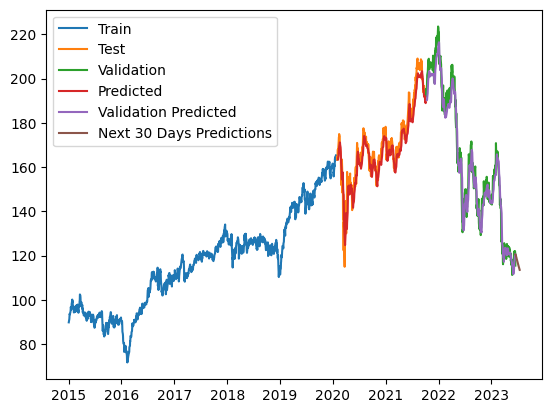

In [17]:
# Tạo danh sách ngày cho trục x
dates_train = df.index[:train_size]
dates_test = df.index[train_size:train_size+test_size]
dates_val = df.index[train_size+test_size:train_size+test_size+val_size]
dates_pred = df.index[train_size+lookback+horizon-1:train_size+test_size]
dates_pred_val = df.index[train_size+test_size+lookback+horizon-1:train_size+test_size+val_size]
dates_next30days = pd.date_range(start=df.index[-1], periods=num_predictions+1)[1:]


# Vẽ biểu đồ
plt.plot(dates_train, scaler.inverse_transform(train_data), label='Train')
plt.plot(dates_test, scaler.inverse_transform(test_data), label='Test')
plt.plot(dates_val, scaler.inverse_transform(val_data), label='Validation')
plt.plot(dates_pred, y_pred, label='Predicted')
plt.plot(dates_pred_val, y_pred_val, label='Validation Predicted')
plt.plot(dates_next30days, next30days_predictions, label='Next 30 Days Predictions')
# plt.xlabel('Date')
# plt.ylabel('Price')
# plt.title('Stock Price Predictions')
plt.legend()
plt.show()

<h2>2. Data ARI-Historical-Data-final

In [18]:
# Import data
df = pd.read_csv('ARI-Historical-Data-final.csv', index_col='Date', parse_dates=True)
df1=df.reset_index()['Price']

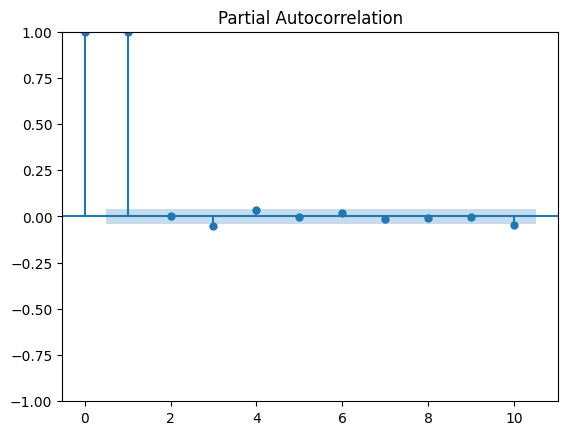

In [19]:
# Kiểm tra sự tương quan một phần PAFC
plot_pacf(df1, lags=10)
plt.show()

In [20]:
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [21]:
# Chia thành các tập train, test, validation
train_size = int(0.6 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [22]:
# Hàm tạo dữ liệu cho mô hình
def create_dataset(dataset, lookback, horizon):
    X, y = [], []
    for i in range(len(dataset)-lookback-horizon+1):
        X.append(dataset[i:(i+lookback), :])
        y.append(dataset[(i+lookback):(i+lookback+horizon), 0])
    return np.array(X), np.array(y)

In [23]:
# Chọn các giá trị lookback, horizon, n_features
lookback = 3
horizon = 1
n_features = 1

In [24]:
X_train, y_train = create_dataset(train_data, lookback, horizon)
X_test, y_test = create_dataset(test_data, lookback, horizon)
X_val, y_val = create_dataset(val_data, lookback, horizon)

In [25]:
# Xây dựng mô hình NNAR
model = Sequential()
model.add(LSTM(64, input_shape=(lookback, n_features), return_sequences=True))
model.add(LSTM(32, return_sequences=False))
model.add(Dense(horizon))
model.compile(loss='mse', optimizer='adam')

In [26]:
# Huấn luyện mô hình
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), verbose=2)

Epoch 1/50
40/40 - 3s - loss: 0.2246 - val_loss: 0.0193 - 3s/epoch - 77ms/step
Epoch 2/50
40/40 - 0s - loss: 0.0023 - val_loss: 0.0158 - 138ms/epoch - 3ms/step
Epoch 3/50
40/40 - 0s - loss: 6.4902e-04 - val_loss: 0.0178 - 138ms/epoch - 3ms/step
Epoch 4/50
40/40 - 0s - loss: 5.9728e-04 - val_loss: 0.0167 - 137ms/epoch - 3ms/step
Epoch 5/50
40/40 - 0s - loss: 5.8396e-04 - val_loss: 0.0166 - 139ms/epoch - 3ms/step
Epoch 6/50
40/40 - 0s - loss: 5.4897e-04 - val_loss: 0.0155 - 136ms/epoch - 3ms/step
Epoch 7/50
40/40 - 0s - loss: 5.2286e-04 - val_loss: 0.0143 - 139ms/epoch - 3ms/step
Epoch 8/50
40/40 - 0s - loss: 5.0121e-04 - val_loss: 0.0132 - 138ms/epoch - 3ms/step
Epoch 9/50
40/40 - 0s - loss: 4.7293e-04 - val_loss: 0.0131 - 137ms/epoch - 3ms/step
Epoch 10/50
40/40 - 0s - loss: 4.4636e-04 - val_loss: 0.0117 - 137ms/epoch - 3ms/step
Epoch 11/50
40/40 - 0s - loss: 4.1498e-04 - val_loss: 0.0110 - 140ms/epoch - 4ms/step
Epoch 12/50
40/40 - 0s - loss: 3.8855e-04 - val_loss: 0.0101 - 136ms/epoc

In [27]:
y_pred = model.predict(X_test)
y_pred_val = model.predict(X_val)

14/14 [==============================] - 0s 1ms/step


In [28]:
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test)
y_val=scaler.inverse_transform(y_val)
y_pred_val = scaler.inverse_transform(y_pred_val)

In [29]:
# Đánh giá độ chính xác
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
test_mae = np.mean(np.abs(y_pred - y_test))
valid_mae = np.mean(np.abs(y_pred_val - y_val))
test_mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
valid_mape = np.mean(np.abs((y_val - y_pred_val) / y_val)) * 100
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('Testing MAE:', test_mae)
print('Validation MAE:', valid_mae)
print('Testing MAPE:', test_mape)
print('Validation MAPE:', valid_mape)

Validation RMSE: 0.8066297118036121
Testing RMSE: 1.0534696992597867
Testing MAE: 0.7840941562019816
Validation MAE: 0.6853669691085812
Testing MAPE: 8.417919351808823
Validation MAPE: 6.241121047377111


In [30]:
# Tạo một danh sách mới
y_pred = [y_pred[i][0] for i in range(len(y_pred))]
y_pred_val = [y_pred_val[i][0] for i in range(len(y_pred_val))]

In [31]:
# Dự đoán 30 ngày tiếp theo
num_predictions = 30
initial_input = X_val[-1]
initial_input = initial_input.reshape(1, lookback, n_features)
next30days_predictions = []
for _ in range(num_predictions):
    next_pred = model.predict(initial_input)
    next30days_predictions.append(next_pred[0])
    initial_input = np.append(initial_input[:, 1:, :], next_pred.reshape(1, horizon, n_features), axis=1)
# next30days_predictions = np.array(next30days_predictions).reshape(-1, 1)
next30days_predictions = scaler.inverse_transform(next30days_predictions)

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 16ms/step


In [32]:
# Trích xuất giá trị dự đoán vào danh sách mới
next30days_predictions=[next30days_predictions[i][0] for i in range(len(next30days_predictions))]

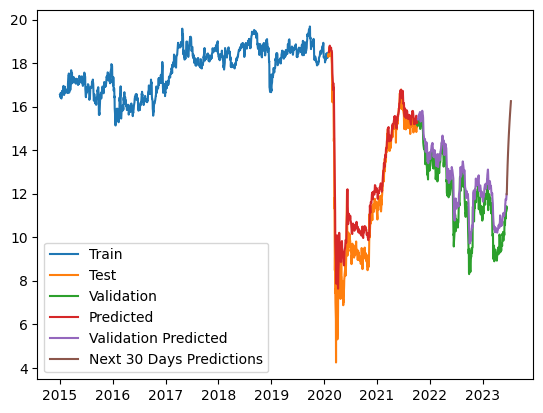

In [33]:
# Tạo danh sách ngày cho trục x
dates_train = df.index[:train_size]
dates_test = df.index[train_size:train_size+test_size]
dates_val = df.index[train_size+test_size:train_size+test_size+val_size]
dates_pred = df.index[train_size+lookback+horizon-1:train_size+test_size]
dates_pred_val = df.index[train_size+test_size+lookback+horizon-1:train_size+test_size+val_size]
dates_next30days = pd.date_range(start=df.index[-1], periods=num_predictions+1)[1:]


# Vẽ biểu đồ
plt.plot(dates_train, scaler.inverse_transform(train_data), label='Train')
plt.plot(dates_test, scaler.inverse_transform(test_data), label='Test')
plt.plot(dates_val, scaler.inverse_transform(val_data), label='Validation')
plt.plot(dates_pred, y_pred, label='Predicted')
plt.plot(dates_pred_val, y_pred_val, label='Validation Predicted')
plt.plot(dates_next30days, next30days_predictions, label='Next 30 Days Predictions')
# plt.xlabel('Date')
# plt.ylabel('Price')
# plt.title('Stock Price Predictions')
plt.legend()
plt.show()

<h2>3. Data MAA-Historical-Data-final

In [34]:
# Import data
df = pd.read_csv('MAA-Historical-Data-final.csv', index_col='Date', parse_dates=True)
df1=df.reset_index()['Price']

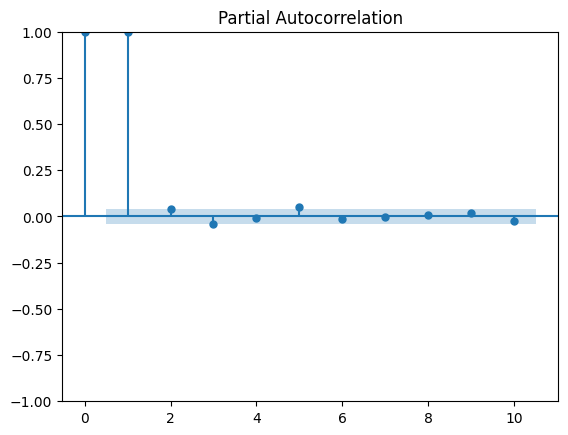

In [35]:
# Kiểm tra sự tương quan một phần PAFC
plot_pacf(df1, lags=10)
plt.show()

In [36]:
# Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [37]:
# Chia thành các tập train, test, validation
train_size = int(0.6 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [38]:
# Hàm tạo dữ liệu cho mô hình
def create_dataset(dataset, lookback, horizon):
    X, y = [], []
    for i in range(len(dataset)-lookback-horizon+1):
        X.append(dataset[i:(i+lookback), :])
        y.append(dataset[(i+lookback):(i+lookback+horizon), 0])
    return np.array(X), np.array(y)

In [39]:
# Thiết lập thông số mô hình
lookback = 5
horizon = 1
n_features = 1

In [40]:
# Tạo dữ liệu cho mô hình
X_train, y_train = create_dataset(train_data, lookback, horizon)
X_test, y_test = create_dataset(test_data, lookback, horizon)
X_val, y_val = create_dataset(val_data, lookback, horizon)

In [41]:
# Xây dựng mô hình NNAR
model = Sequential()
model.add(LSTM(64, input_shape=(lookback, n_features), return_sequences=True))
model.add(LSTM(32, return_sequences=False))
model.add(Dense(horizon))
model.compile(loss='mse', optimizer='adam')

In [42]:
# Huấn luyện mô hình
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), verbose=2)

Epoch 1/50
40/40 - 3s - loss: 0.0083 - val_loss: 0.0423 - 3s/epoch - 76ms/step
Epoch 2/50
40/40 - 0s - loss: 5.4527e-04 - val_loss: 0.0146 - 172ms/epoch - 4ms/step
Epoch 3/50
40/40 - 0s - loss: 1.6528e-04 - val_loss: 0.0046 - 171ms/epoch - 4ms/step
Epoch 4/50
40/40 - 0s - loss: 1.5281e-04 - val_loss: 0.0040 - 186ms/epoch - 5ms/step
Epoch 5/50
40/40 - 0s - loss: 1.5154e-04 - val_loss: 0.0025 - 170ms/epoch - 4ms/step
Epoch 6/50
40/40 - 0s - loss: 1.4880e-04 - val_loss: 0.0022 - 171ms/epoch - 4ms/step
Epoch 7/50
40/40 - 0s - loss: 1.4830e-04 - val_loss: 0.0013 - 208ms/epoch - 5ms/step
Epoch 8/50
40/40 - 0s - loss: 1.4638e-04 - val_loss: 0.0011 - 235ms/epoch - 6ms/step
Epoch 9/50
40/40 - 0s - loss: 1.4434e-04 - val_loss: 0.0014 - 241ms/epoch - 6ms/step
Epoch 10/50
40/40 - 0s - loss: 1.4260e-04 - val_loss: 0.0011 - 237ms/epoch - 6ms/step
Epoch 11/50
40/40 - 0s - loss: 1.4782e-04 - val_loss: 9.6513e-04 - 173ms/epoch - 4ms/step
Epoch 12/50
40/40 - 0s - loss: 1.4779e-04 - val_loss: 0.0013 - 22

In [43]:

y_pred = model.predict(X_test)
y_pred_val = model.predict(X_val)

14/14 [==============================] - 0s 1ms/step


In [44]:
#Scale lại các giá trị
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test)
y_val=scaler.inverse_transform(y_val)
y_pred_val = scaler.inverse_transform(y_pred_val)

In [45]:
# Đánh giá độ chính xác
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
test_mae = np.mean(np.abs(y_pred - y_test))
valid_mae = np.mean(np.abs(y_pred_val - y_val))
test_mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
valid_mape = np.mean(np.abs((y_val - y_pred_val) / y_val)) * 100
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('Testing MAE:', test_mae)
print('Validation MAE:', valid_mae)
print('Testing MAPE:', test_mape)
print('Validation MAPE:', valid_mape)

Validation RMSE: 4.44113226354995
Testing RMSE: 4.226434187522584
Testing MAE: 2.7822205113002227
Validation MAE: 3.5191235756535098
Testing MAPE: 2.213442463168107
Validation MAPE: 2.013556775083263


In [46]:
# Tạo một danh sách mới
y_pred = [y_pred[i][0] for i in range(len(y_pred))]
y_pred_val = [y_pred_val[i][0] for i in range(len(y_pred_val))]

In [47]:
# Dự đoán 30 ngày tiếp theo
num_predictions = 30
initial_input = X_val[-1]
initial_input = initial_input.reshape(1, lookback, n_features)
next30days_predictions = []
for _ in range(num_predictions):
    next_pred = model.predict(initial_input)
    next30days_predictions.append(next_pred[0])
    initial_input = np.append(initial_input[:, 1:, :], next_pred.reshape(1, horizon, n_features), axis=1)
# next30days_predictions = np.array(next30days_predictions).reshape(-1, 1)
next30days_predictions = scaler.inverse_transform(next30days_predictions)

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 17ms/step


In [48]:
# Trích xuất giá trị dự đoán vào danh sách mới
next30days_predictions=[next30days_predictions[i][0] for i in range(len(next30days_predictions))]

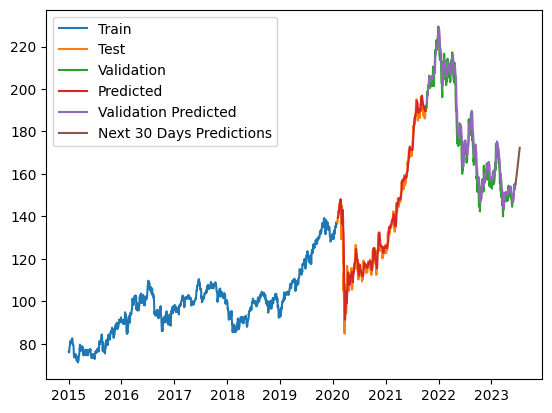

In [49]:
# Tạo danh sách ngày cho trục x
dates_train = df.index[:train_size]
dates_test = df.index[train_size:train_size+test_size]
dates_val = df.index[train_size+test_size:train_size+test_size+val_size]
dates_pred = df.index[train_size+lookback+horizon-1:train_size+test_size]
dates_pred_val = df.index[train_size+test_size+lookback+horizon-1:train_size+test_size+val_size]
dates_next30days = pd.date_range(start=df.index[-1], periods=num_predictions+1)[1:]


# Vẽ biểu đồ
plt.plot(dates_train, scaler.inverse_transform(train_data), label='Train')
plt.plot(dates_test, scaler.inverse_transform(test_data), label='Test')
plt.plot(dates_val, scaler.inverse_transform(val_data), label='Validation')
plt.plot(dates_pred, y_pred, label='Predicted')
plt.plot(dates_pred_val, y_pred_val, label='Validation Predicted')
plt.plot(dates_next30days, next30days_predictions, label='Next 30 Days Predictions')
# plt.xlabel('Date')
# plt.ylabel('Price')
# plt.title('Stock Price Predictions')
plt.legend()
plt.show()